In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
pip install scikit-plot==0.3.7

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from statsmodels.tsa.vector_ar.var_model import VAR
import scikitplot as skplt

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from scipy.stats import kurtosis
from scipy.stats import ks_2samp
from scipy.stats import mode
from sklearn.svm import OneClassSVM
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import accuracy_score, mean_squared_error

In [ ]:
class DataStreamer:
    
    def __init__(self, filename, block_size):

        self.filename =  filename
        self.block_size = block_size
        self.cur_index = 0;
        self.data = pd.read_excel(filename)
        self.row_size = len(self.data)
        
    def print_meta(self):
        
        print('File Name\t:\t', self.filename)
        print('Block Size\t:\t', self.block_size)
        print('Current Index\t:\t', self.cur_index)
        print('Data length\t:\t',self.row_size)
        
    def reset(self):
        
        self.cur_index = 0
        
    def get_next_block(self):
        
        if self.cur_index+self.block_size+1 > self.row_size:
            block = self.data.iloc[self.cur_index:,:]
        else: 
            block = self.data.iloc[self.cur_index:self.cur_index+self.block_size,:]
        self.cur_index=self.cur_index+self.block_size
        return block.values
    
    def has_next(self):
        
        if self.cur_index>=self.row_size:
            return False
        return True
    
    def get_full_stream(self):
        
        return self.data.values

    def get_block_size(self):
      
        return self.block_size

    def get_row_size(self):

        return self.row_size

In [ ]:
streamer =  DataStreamer('GOOGL.xlsx', 100)
streamer.print_meta()

print(streamer.has_next())

File Name	:	 GOOGL.xlsx
Block Size	:	 100
Current Index	:	 0
Data length	:	 3932
True


In [ ]:
window_size = streamer.get_block_size()

In [ ]:
def process_block(block):

  #Dropping Date and Time columns respectively 
  df_block = pd.DataFrame(block)
  df_block = df_block.drop([0], axis=1)

  #Replacing 'NaN' values with 0
  for j in df_block.columns:
    for i in range(0, len(df_block)):
      if df_block[j][i] == -200:
        df_block[j][i] = 0
        
  #Adding columns to dictionary   
  block_cols = {}
  for col in df_block.columns:
    block_cols[col] = df_block[col]
  return block_cols

In [ ]:
def compare_dictionaries(dict1, dict2):
 
    num_rejected = 0
    num_values = 0
    bool_dict = {}

    for key1, key2 in zip(dict1, dict2):
        stat, p_value = ks_2samp(dict1[key1], dict2[key2])
        
        if p_value <= 0.01:
            num_rejected += 1
            bool_dict[key1] = True
        else:
            bool_dict[key1] = False
        num_values += 1
    
    pct_rejected = num_rejected / num_values
    
    return pct_rejected >= 0.7, bool_dict

In [ ]:
def stat_extraction(cols1, cols2):
  stat_df = pd.DataFrame()

  stat_df['Mode_1'] = mode(np.asarray(cols1))[0]

  stat_df['Mean_2'] = np.mean(cols2)
  stat_df['Median_2'] = np.median(cols2)
  stat_df['Mode_2'] = mode(np.asarray(cols2))[0]

  stat_df['Std_1'] = np.std(np.asarray(cols1))
  stat_df['Std_2'] = np.std(np.asarray(cols2))

  stat_df['Kurtosis_1'] = kurtosis(np.asarray(cols1, dtype = float))
  stat_df['Kurtosis_2'] = kurtosis(np.asarray(cols2, dtype = float))  

  stat_df['Mean_1'] = np.mean(cols1)
  stat_df['Median_1'] = np.median(cols1)
            
  return stat_df

In [ ]:
block1 = streamer.get_next_block()
block2 = streamer.get_next_block()
feature_dfs = {}
stats_df = {}

block1_cols = process_block(block1)

#Creating dictionaries to hold dataframes for both entire features and extracted statistics for each feature separately  
for key in block1_cols:
  feature_dfs[f'feature_{key}'] = pd.DataFrame(columns = ["Class"])
  stats_df[f'stats_{key}'] = pd.DataFrame(columns = ["Class"])

while block2.shape[0] not in [streamer.get_row_size() % window_size]:
    
    block1_cols, block2_cols = process_block(block1), process_block(block2)
    result, feature_result = compare_dictionaries(block1_cols, block2_cols)

    for key, value in feature_result.items():
      stat_df = stat_extraction(block1_cols[key], block2_cols[key])
      stat_df['Class'] = value

      stats_df[f'stats_{key}'] = stats_df[f'stats_{key}'].append(stat_df)

    block1 = block2
    block2 = streamer.get_next_block()

In [ ]:
classifiers = {}

Accuracy: 0.75
Accuracy: 0.92
Accuracy: 0.75
Accuracy: 0.83
Accuracy: 0.83
Accuracy: 0.5


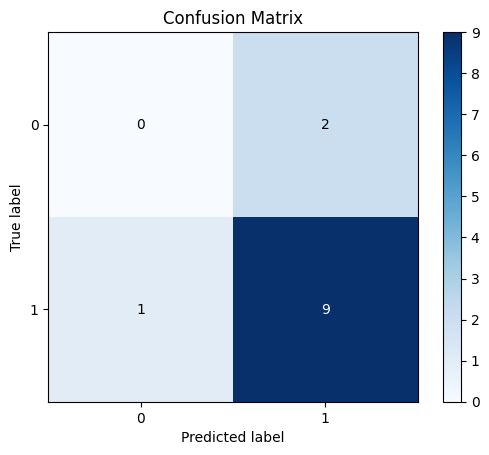

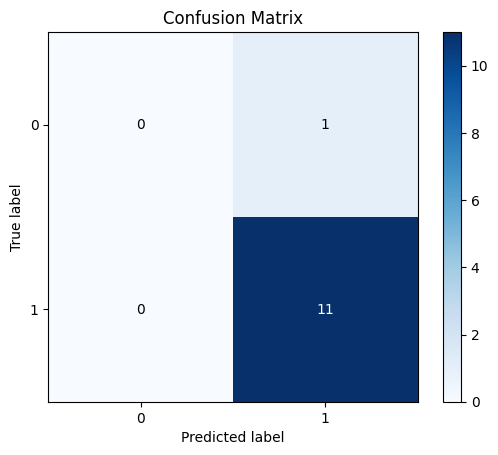

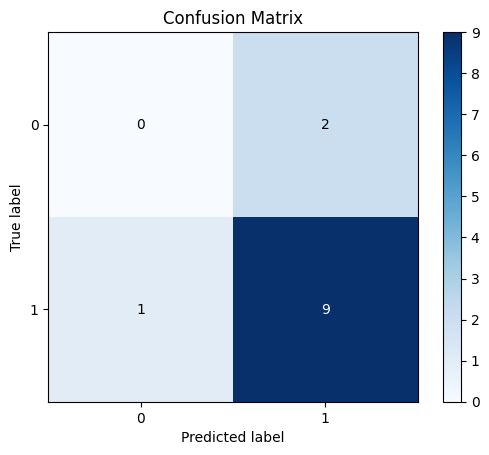

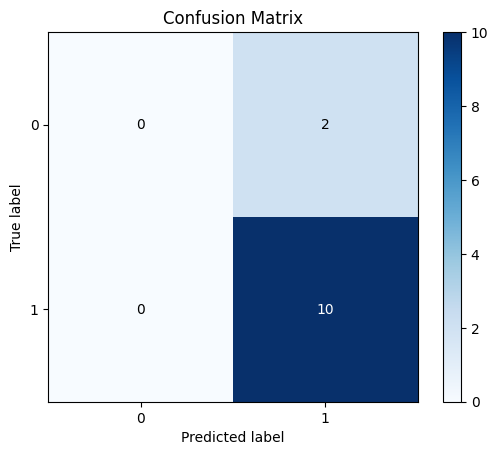

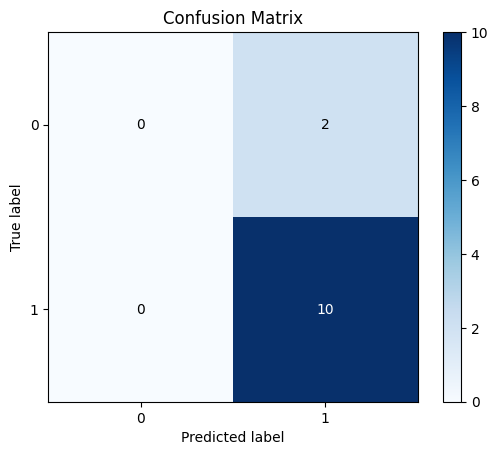

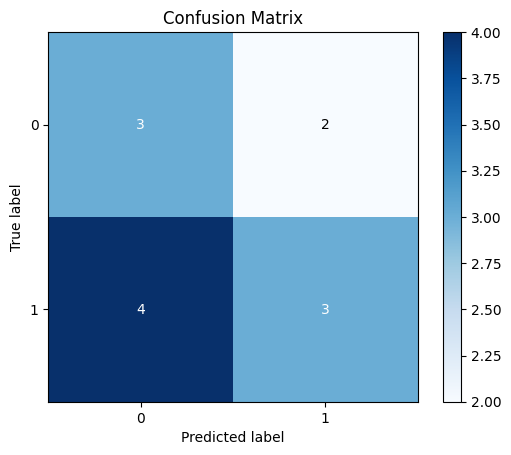

In [ ]:
for key, value in stats_df.items():
  stats_df[key] = stats_df[key].fillna(0)
  stats_df[key] = stats_df[key].reset_index(drop=True)
  X_train, X_test, y_train, y_test = train_test_split(stats_df[key].drop('Class', axis=1), 
                                                      stats_df[key]['Class'].astype('int'), 
                                                      test_size=0.3, 
                                                      random_state=17)
  
  if ((y_train ==0).sum() < 0.01*len(y_train)):
    model = OneClassSVM(gamma='scale', nu=0.01)
    model.fit(X_train)
    y_pred = model.predict(X_test)
    classifiers[key] = model
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {round(accuracy, 2)}')
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=False, title = 'Confusion Matrix')

  else: 
    rf = RandomForestClassifier(n_estimators=100, random_state=17)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    classifiers[key] = rf
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {round(accuracy, 2)}')
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=False, title = 'Confusion Matrix')

In [ ]:
rem = streamer.get_row_size() % window_size

In [ ]:
df = pd.read_excel('GOOGL.xlsx', parse_dates=['Date'])
df = df.drop(df.index[-rem:])

In [ ]:
df['Date'] = pd.to_datetime(df.Date, format = '%d/%m/%Y')

In [ ]:
data = df.drop(['Date'], axis=1)
data.index = df.Date

In [ ]:
def VAR_forecast(dataframe):
  train_df = dataframe[:-2790]
  test_df = dataframe[-2790:]

  model = VAR(endog=train_df)
  model_fit = model.fit()
  
  prediction = model_fit.forecast(model_fit.endog, steps=len(test_df))
  pred = pd.DataFrame(index=range(0,len(prediction)), columns=[data.columns])
  for j in range(0,len(data.columns)):
    for i in range(0, len(prediction)):
      pred.iloc[i][j] = prediction[i][j]

  for i in data.columns:
    print('MAE value for', i, 'is:', round(np.mean(np.abs(np.asarray(test_df[i]) - np.asarray(pred[i]))), 2))
    print('MSE value for', i, 'is:', round(mean_squared_error(pred[i], test_df[i]), 2))
    print('RMSE value for', i, 'is:', round(math.sqrt(mean_squared_error(pred[i], test_df[i])), 2))
    print('MAPE value for', i, 'is:', round(np.mean(np.abs((np.asarray(test_df[i]) - np.asarray(pred[i])) / np.asarray(test_df[i]))), 2))
    print('')

In [ ]:
VAR_forecast(data)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


MAE value for Open is: 410.7
MSE value for Open is: 281708.1
RMSE value for Open is: 530.76
MAPE value for Open is: 0.53

MAE value for High is: 413.2
MSE value for High is: 285713.36
RMSE value for High is: 534.52
MAPE value for High is: 0.53

MAE value for Low is: 408.22
MSE value for Low is: 277872.58
RMSE value for Low is: 527.14
MAPE value for Low is: 0.54

MAE value for Close is: 410.95
MSE value for Close is: 282128.78
RMSE value for Close is: 531.16
MAPE value for Close is: 0.53

MAE value for Adj Close is: 410.95
MSE value for Adj Close is: 282128.78
RMSE value for Adj Close is: 531.16
MAPE value for Adj Close is: 0.53

MAE value for Volume is: 11294693.19
MSE value for Volume is: 132805992131357.45
RMSE value for Volume is: 11524148.22
MAPE value for Volume is: 5.4



In [ ]:
test_dfs = {}

In [ ]:
for column in data.columns:
    test_dfs[f'test_{column}'] = pd.DataFrame()

In [ ]:
for i in range(0, len(data)-window_size):
  current = data.iloc[i:i+window_size]
  next = data.iloc[i+1:i+window_size+1]

  for column in current.columns:
    temp_df = stat_extraction(current[column], next[column])
    test_dfs[f'test_{column}'] = test_dfs[f'test_{column}'].append(temp_df)

In [ ]:
for key, value in test_dfs.items():
  test_dfs[key] = test_dfs[key].fillna(0)

In [ ]:
test_preds = {}

In [ ]:
for test_data, classifier in zip(test_dfs, classifiers):
  test_preds[test_data] = classifiers[classifier].predict(test_dfs[test_data])
  test_preds[test_data] = np.concatenate((np.zeros(window_size), test_preds[test_data]))

In [ ]:
preds = pd.DataFrame.from_dict(test_preds)

In [ ]:
preds = preds.set_index(data.index)
do = pd.concat([data, preds], axis=1)

In [ ]:
VAR_forecast(do)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


MAE value for Open is: 408.34
MSE value for Open is: 279948.78
RMSE value for Open is: 529.1
MAPE value for Open is: 0.53

MAE value for High is: 410.83
MSE value for High is: 283930.12
RMSE value for High is: 532.85
MAPE value for High is: 0.53

MAE value for Low is: 405.89
MSE value for Low is: 276141.88
RMSE value for Low is: 525.49
MAPE value for Low is: 0.53

MAE value for Close is: 408.6
MSE value for Close is: 280368.26
RMSE value for Close is: 529.5
MAPE value for Close is: 0.53

MAE value for Adj Close is: 408.6
MSE value for Adj Close is: 280368.26
RMSE value for Adj Close is: 529.5
MAPE value for Adj Close is: 0.53

MAE value for Volume is: 11452003.28
MSE value for Volume is: 136170918842803.94
RMSE value for Volume is: 11669229.57
MAPE value for Volume is: 5.46



In [ ]:
majority_pred = pd.DataFrame()

In [ ]:
majority_pred['maj'] = preds.mode(axis=1)[0]

In [ ]:
da = pd.concat([data, majority_pred], axis=1)

In [ ]:
VAR_forecast(da)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


MAE value for Open is: 408.34
MSE value for Open is: 279817.51
RMSE value for Open is: 528.98
MAPE value for Open is: 0.53

MAE value for High is: 410.83
MSE value for High is: 283796.34
RMSE value for High is: 532.73
MAPE value for High is: 0.53

MAE value for Low is: 405.89
MSE value for Low is: 276014.31
RMSE value for Low is: 525.37
MAPE value for Low is: 0.53

MAE value for Close is: 408.6
MSE value for Close is: 280236.97
RMSE value for Close is: 529.37
MAPE value for Close is: 0.53

MAE value for Adj Close is: 408.6
MSE value for Adj Close is: 280236.97
RMSE value for Adj Close is: 529.37
MAPE value for Adj Close is: 0.53

MAE value for Volume is: 11453585.26
MSE value for Volume is: 136252496521005.73
RMSE value for Volume is: 11672724.47
MAPE value for Volume is: 5.47



In [ ]:
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

In [ ]:
def LSTM_forecast(LSTM_data):
  scaler = StandardScaler()
  scaled_data = scaler.fit_transform(LSTM_data)

  train_size = int(len(scaled_data) * 0.8)
  train_data = scaled_data[:train_size]
  test_data = scaled_data[train_size:]

  n_steps = 10

  X_train, y_train = create_sequences(train_data, n_steps)
  X_test, y_test = create_sequences(test_data, n_steps)


  n_features = LSTM_data.shape[1]  
  model = Sequential()
  model.add(LSTM(units=50, activation='relu', input_shape=(n_steps, n_features)))
  model.add(Dense(n_features)) 
  model.compile(optimizer='adam', loss='mse')

  model.fit(X_train, y_train, epochs=10, batch_size=16)

  y_pred = model.predict(X_test)

  predicted_data = scaler.inverse_transform(y_pred)

  predicted_df = pd.DataFrame(predicted_data, columns=LSTM_data.columns)

  y_test = scaler.inverse_transform(y_test)

  y_test_df =  pd.DataFrame(y_test, columns=LSTM_data.columns)

  print('')
  print('')
  for i in data.columns:
    print('MAE value for', i, 'is:', round(np.mean(np.abs(np.asarray(y_test_df[i]) - np.asarray(predicted_df[i]))), 2))
    print('MSE value for', i, 'is:', round(mean_squared_error(predicted_df[i], y_test_df[i]), 2))
    print('RMSE value for', i, 'is:', round(math.sqrt(mean_squared_error(predicted_df[i], y_test_df[i])), 2))
    print('MAPE value for', i, 'is:', round(np.mean(np.abs((np.asarray(y_test_df[i]) - np.asarray(predicted_df[i])) / np.asarray(y_test_df[i]))), 2))
    print('')

In [ ]:
LSTM_forecast(data)

Epoch 1/10
195/195 [==============================] - 3s 7ms/step - loss: 0.1095
Epoch 2/10
195/195 [==============================] - 2s 10ms/step - loss: 0.0616
Epoch 3/10
195/195 [==============================] - 2s 9ms/step - loss: 0.0595
Epoch 4/10
195/195 [==============================] - 1s 7ms/step - loss: 0.0580
Epoch 5/10
195/195 [==============================] - 1s 7ms/step - loss: 0.0572
Epoch 6/10
195/195 [==============================] - 1s 7ms/step - loss: 0.0565
Epoch 7/10
195/195 [==============================] - 1s 7ms/step - loss: 0.0557
Epoch 8/10
195/195 [==============================] - 1s 7ms/step - loss: 0.0551
Epoch 9/10
195/195 [==============================] - 1s 7ms/step - loss: 0.0553
Epoch 10/10
25/25 [==============================] - 0s 4ms/step


MAE value for Open is: 73.41
MSE value for Open is: 9012.97
RMSE value for Open is: 94.94
MAPE value for Open is: 0.06

MAE value for High is: 41.14
MSE value for High is: 3716.92
RMSE value for High is:

In [ ]:
LSTM_forecast(do)

Epoch 1/10
195/195 [==============================] - 4s 8ms/step - loss: 0.1351
Epoch 2/10
195/195 [==============================] - 1s 7ms/step - loss: 0.0543
Epoch 3/10
195/195 [==============================] - 1s 7ms/step - loss: 0.0517
Epoch 4/10
195/195 [==============================] - 1s 7ms/step - loss: 0.0475
Epoch 5/10
195/195 [==============================] - 1s 7ms/step - loss: 0.0472
Epoch 6/10
195/195 [==============================] - 1s 7ms/step - loss: 0.0445
Epoch 7/10
195/195 [==============================] - 2s 8ms/step - loss: 0.0432
Epoch 8/10
195/195 [==============================] - 2s 10ms/step - loss: 0.0427
Epoch 9/10
195/195 [==============================] - 2s 8ms/step - loss: 0.0434
Epoch 10/10
25/25 [==============================] - 0s 3ms/step


MAE value for Open is: 118.76
MSE value for Open is: 96400.15
RMSE value for Open is: 310.48
MAPE value for Open is: 0.1

MAE value for High is: 66.11
MSE value for High is: 17606.74
RMSE value for High 

In [ ]:
LSTM_forecast(da)

Epoch 1/10
195/195 [==============================] - 3s 7ms/step - loss: 0.1176
Epoch 2/10
195/195 [==============================] - 1s 7ms/step - loss: 0.0572
Epoch 3/10
195/195 [==============================] - 2s 11ms/step - loss: 0.0538
Epoch 4/10
195/195 [==============================] - 2s 13ms/step - loss: 0.0522
Epoch 5/10
195/195 [==============================] - 2s 8ms/step - loss: 0.0508
Epoch 6/10
195/195 [==============================] - 1s 7ms/step - loss: 0.0500
Epoch 7/10
195/195 [==============================] - 1s 7ms/step - loss: 0.0504
Epoch 8/10
195/195 [==============================] - 1s 7ms/step - loss: 0.0505
Epoch 9/10
195/195 [==============================] - 1s 7ms/step - loss: 0.0496
Epoch 10/10
25/25 [==============================] - 0s 3ms/step


MAE value for Open is: 24.93
MSE value for Open is: 1397.64
RMSE value for Open is: 37.38
MAPE value for Open is: 0.02

MAE value for High is: 38.83
MSE value for High is: 2173.38
RMSE value for High is